### aim: calculate SO Cflx!

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [4]:
ukmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask_eORCA1_wrk.nc')
ukmesh['area'] = ukmesh.tmask[0,:,:] * ukmesh.e1t[:,:] * ukmesh.e2t[:,:]

ukmesh.nav_lat[0:114,0]

<xarray.DataArray 'nav_lat' (y: 114)>
array([-84.21071 , -84.108955, -84.005424, -83.90008 , -83.79289 , -83.68382 ,
       -83.572845, -83.45993 , -83.34504 , -83.22814 , -83.1092  , -82.988174,
       -82.865036, -82.739746, -82.612274, -82.48257 , -82.3506  , -82.21633 ,
       -82.07972 , -81.94073 , -81.79932 , -81.65543 , -81.50905 , -81.360115,
       -81.20859 , -81.05442 , -80.89758 , -80.73801 , -80.57567 , -80.4105  ,
       -80.24247 , -80.071526, -79.89762 , -79.720695, -79.54071 , -79.357605,
       -79.17133 , -78.98184 , -78.78908 , -78.59298 , -78.3935  , -78.19058 ,
       -77.98417 , -77.7742  , -77.56062 , -77.34337 , -77.12238 , -76.89761 ,
       -76.66898 , -76.43644 , -76.19991 , -75.95934 , -75.71467 , -75.46582 ,
       -75.21273 , -74.95534 , -74.693565, -74.42735 , -74.156624, -73.88131 ,
       -73.60134 , -73.31665 , -73.02715 , -72.73279 , -72.43347 , -72.129135,
       -71.8197  , -71.5051  , -71.185234, -70.86005 , -70.52946 , -70.193375,
       -69.85174 , -69.50445 , -69.151436, -68.792625, -68.427925, -68.05725 ,
       -67.680534, -67.29768 , -66.90862 , -66.51326 , -66.11152 , -65.703316,
       -65.28857 , -64.867195, -64.4391  , -64.00423 , -63.56247 , -63.113754,
       -62.658   , -62.195126, -61.725048, -61.247692, -60.762974, -60.27082 ,
       -59.77115 , -59.263885, -58.748955, -58.226284, -57.695797, -57.15743 ,
       -56.61111 , -56.05677 , -55.494347, -54.923775, -54.344994, -53.75795 ,
       -53.162582, -52.558838, -51.946674, -51.326035, -50.696884, -50.059177],
      dtype=float32)
Dimensions without coordinates: y

In [5]:
scendict = {
    # Baynes Sound
    '1A': {
        'hist_str': 'bc370',
        'fut_str': 'be682',
        'name': 'HIST.OZONE \n LOW TEMP.',
        'name2':'1A: NatlOzone-SSP126',
        'color':'#E8D215',
        'color2':'orange'},
    '1B': {
        'hist_str': 'bc370',
        'fut_str': 'ce417',
        'name': 'HIST. OZONE \n HIGH TEMP.',
        'name2':'1B: NatlOzone-SSP370',
        'color':'#87800A',
        'color2':'orangered'},
    '2A': {
        'hist_str': 'cj198',
        'fut_str': 'cj880',
        'name': 'FIXED OZONE \n LOW TEMP.',
        'name2':'2A: Ozone1950-SSP126',
        'color':'#2DC18E',
        'color2':'mediumseagreen'},
    '2B': {
        'hist_str': 'cj198',
        'fut_str': 'cj881',
        'name': 'FIXED OZONE \n HIGH TEMP.',
        'name2':'2B: Ozone1950-SSP370',
        'color':'#18765C',
        'color2':'green'},
    '3A': {
        'hist_str': 'cj200',
        'fut_str': 'cj484',
        'name': '1990 OZONE \n LOW TEMP.',
        'name2':'3A: Ozone1990-SSP126',
        'color':'#FF462B',
        'color2':'dodgerblue'},
    '3B': {
        'hist_str': 'cj200',
        'fut_str': 'cj504',
        'name': '1990 OZONE \n HIGH TEMP.',
        'name2':'3B: Ozone1990-SSP370',
        'color':'#822722',
        'color2':'mediumblue'}
}

In [6]:
extract = False
if extract:


    def make_yearlist_ukesm(yrst, yren, tscen, dtype = 'grid-T'):
        print(f'SCENARIO {tscen}')
        dslist = []

        for y in range(yrst,yren):
            if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
                tstr = scendict['1A']['hist_str']
            elif y<2015:
                tstr = scendict[tscen]['hist_str']

            else:
                tstr = scendict[tscen]['fut_str']

            try:
                td = glob.glob(f'/gpfs/data/greenocean/software/resources/MEDUSA/PROC2/*{tstr}*{y}*{dtype}*')
                dslist.append(td[0])
            except:
                pass
                print(f'FAIL {tscen},{tstr}, {y}')
        return dslist


    ### 
    ukmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask_eORCA1_wrk.nc')
    ukmesh['area'] = ukmesh.tmask[0,:,:] * ukmesh.e1t[:,:] * ukmesh.e2t[:,:]
    #print('lol yes the area is correct now')

    ukesm1A = (make_yearlist_ukesm(1950,2100,'1A', dtype = 'aux'))
    ukesm1B = (make_yearlist_ukesm(1950,2100,'1B', dtype = 'aux'))
    ukesm2A = (make_yearlist_ukesm(1950,2100,'2A', dtype = 'aux'))
    ukesm2B = (make_yearlist_ukesm(1950,2100,'2B', dtype = 'aux'))
    ukesm3A = (make_yearlist_ukesm(1950,2100,'3A', dtype = 'aux'))
    ukesm3B = (make_yearlist_ukesm(1950,2100,'3B', dtype = 'aux'))

    def get_monthly_co2(ukesmlist, savenam):
        print(savenam)
        time1 = time.time()
        print(len(ukesmlist))
        cflx_array = np.zeros(len(ukesmlist))
        year = np.zeros(len(ukesmlist))
        for i in range(0,len(ukesmlist)):
            if i%10 == 0:
                print(i)
            test = xr.open_dataset(ukesmlist[i])
            byarea = test.CO2FLUX.sel(y=slice(0,114))*ukmesh.area.sel(y=slice(0,114))
            timed = byarea.sum(dim = ['y', 'x']) #
            timed_mmol_day = timed.groupby('time_counter.year').mean() * 1e-18 * 365 * 12 #mmol/day to pG/year
            year[i] = (timed_mmol_day.year.values)
            print(year[i])
            cflx_array[i] = (timed_mmol_day.values)


        data_vars = {'Cflx':(['year'], cflx_array,
        {'units': 'Pg/yr',
        'long_name':'Cflx'}),
        }
        # define coordinates
        coords = {'year': (['year'], year),
                }
        # define global attributes
        attrs = {'made in':'SOZONEwindAnalyis/oceanFields/cflx.ipynb',
        'desc': 'yearly medusa files, saving only variables of interest'
        }
        ds = xr.Dataset(data_vars=data_vars,
        coords=coords,
        attrs=attrs)
        ds.to_netcdf(savenam)

        time2 = time.time()
        print(time2-time1)

    get_yearly_co2(ukesm1A, './extracted-summary/Cflx_ukesm1A_SO.nc')
    get_yearly_co2(ukesm1B, './extracted-summary/Cflx_ukesm1B_SO.nc')
    get_yearly_co2(ukesm2A, './extracted-summary/Cflx_ukesm2A_SO.nc')
    get_yearly_co2(ukesm2B, './extracted-summary/Cflx_ukesm2B_SO.nc')
    get_yearly_co2(ukesm3A, './extracted-summary/Cflx_ukesm3A_SO.nc')
    get_yearly_co2(ukesm3B, './extracted-summary/Cflx_ukesm3B_SO.nc')

In [7]:
extract = True
if extract:
    scendict = {
        # Baynes Sound
        '1A': {
            'hist_str': 'bc370',
            'fut_str': 'be682',
            'name': 'HIST.OZONE \n LOW TEMP.',
            'name2':'1A: NatlOzone-SSP126',
            'color':'#E8D215',
            'color2':'orange'},
        '1B': {
            'hist_str': 'bc370',
            'fut_str': 'ce417',
            'name': 'HIST. OZONE \n HIGH TEMP.',
            'name2':'1B: NatlOzone-SSP370',
            'color':'#87800A',
            'color2':'orangered'},
        '2A': {
            'hist_str': 'cj198',
            'fut_str': 'cj880',
            'name': 'FIXED OZONE \n LOW TEMP.',
            'name2':'2A: Ozone1950-SSP126',
            'color':'#2DC18E',
            'color2':'mediumseagreen'},
        '2B': {
            'hist_str': 'cj198',
            'fut_str': 'cj881',
            'name': 'FIXED OZONE \n HIGH TEMP.',
            'name2':'2B: Ozone1950-SSP370',
            'color':'#18765C',
            'color2':'green'},
        '3A': {
            'hist_str': 'cj200',
            'fut_str': 'cj484',
            'name': '1990 OZONE \n LOW TEMP.',
            'name2':'3A: Ozone1990-SSP126',
            'color':'#FF462B',
            'color2':'dodgerblue'},
        '3B': {
            'hist_str': 'cj200',
            'fut_str': 'cj504',
            'name': '1990 OZONE \n HIGH TEMP.',
            'name2':'3B: Ozone1990-SSP370',
            'color':'#822722',
            'color2':'mediumblue'}
    }

    def make_yearlist_ukesm(yrst, yren, tscen, dtype = 'grid-T'):
        print(f'SCENARIO {tscen}')
        dslist = []

        for y in range(yrst,yren):
            if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
                tstr = scendict['1A']['hist_str']
            elif y<2015:
                tstr = scendict[tscen]['hist_str']

            else:
                tstr = scendict[tscen]['fut_str']

            try:
                td = glob.glob(f'/gpfs/data/greenocean/software/resources/MEDUSA/PROC2/*{tstr}*{y}*{dtype}*')
                dslist.append(td[0])
            except:
                pass
                print(f'FAIL {tscen},{tstr}, {y}')
        return dslist


    ### 
    ukmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask_eORCA1_wrk.nc')
    ukmesh['area'] = ukmesh.tmask[0,:,:] * ukmesh.e1t[:,:] * ukmesh.e2t[:,:]
    #print('lol yes the area is correct now')

    ukesm1A = (make_yearlist_ukesm(1950,2100,'1A', dtype = 'aux'))
    ukesm1B = (make_yearlist_ukesm(1950,2100,'1B', dtype = 'aux'))
    ukesm2A = (make_yearlist_ukesm(1950,2100,'2A', dtype = 'aux'))
    ukesm2B = (make_yearlist_ukesm(1950,2100,'2B', dtype = 'aux'))
    ukesm3A = (make_yearlist_ukesm(1950,2100,'3A', dtype = 'aux'))
    ukesm3B = (make_yearlist_ukesm(1950,2100,'3B', dtype = 'aux'))

    def get_yearly_co2(ukesmlist, savenam):
        print(savenam)
        time1 = time.time()
        print(len(ukesmlist))
        cflx_array = np.zeros(len(ukesmlist)*12)
        times = pd.date_range(f"{1950}/01/01",f"{2100}/01/01",freq='MS',closed='left')
        year = np.zeros(len(ukesmlist))
        ind = 0
        for i in range(0,len(ukesmlist)):
            if i%10 == 0:
                print(i)
            test = xr.open_dataset(ukesmlist[i])
            byarea = test.CO2FLUX.sel(y=slice(0,114))*ukmesh.area.sel(y=slice(0,114))
            timed = byarea.sum(dim = ['y', 'x']) * 1e-18 * 365 * 12 ##mmol/day to pG/year
            
            
            cflx_array[ind:ind+12] = (timed)
            ind = ind+12



        data_vars = {'Cflx':(['time_counter'], cflx_array,
        {'units': 'Pg/yr',
        'long_name':'Cflx'}),
        }
        # define coordinates
        coords = {'time_counter': (['time_counter'], times),
                }
        # define global attributes
        attrs = {'made in':'SOZONE/windAnalyis/oceanFields/prim-prod.ipynb',
        'desc': 'yearly meduA7 files, A7ving only variables of interest'
        }
        ds = xr.Dataset(data_vars=data_vars,
        coords=coords,
        attrs=attrs)
        ds.to_netcdf(savenam)

        time2 = time.time()
        print(time2-time1)
            
            
        

    get_yearly_co2(ukesm1A, './extracted-summary/CflxTS_ukesm_1A_SO.nc')
    get_yearly_co2(ukesm1B, './extracted-summary/CflxTS_ukesm_1B_SO.nc')
    get_yearly_co2(ukesm2A, './extracted-summary/CflxTS_ukesm_2A_SO.nc')
    get_yearly_co2(ukesm2B, './extracted-summary/CflxTS_ukesm_2B_SO.nc')
    get_yearly_co2(ukesm3A, './extracted-summary/CflxTS_ukesm_3A_SO.nc')
    get_yearly_co2(ukesm3B, './extracted-summary/CflxTS_ukesm_3B_SO.nc')

SCENARIO 1A
SCENARIO 1B
SCENARIO 2A
SCENARIO 2B
SCENARIO 3A
SCENARIO 3B
./extracted-summary/CflxTS_ukesm_1A_SO.nc
150
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
41.09545016288757
./extracted-summary/CflxTS_ukesm_1B_SO.nc
150
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
30.778102159500122
./extracted-summary/CflxTS_ukesm_2A_SO.nc
150
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
37.45025086402893
./extracted-summary/CflxTS_ukesm_2B_SO.nc
150
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
30.01572012901306
./extracted-summary/CflxTS_ukesm_3A_SO.nc
150
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
32.38512063026428
./extracted-summary/CflxTS_ukesm_3B_SO.nc
150
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
30.193416833877563


In [8]:
# baseDir = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/'
# #wspd_PI = xr.open_dataset(f'{baseDir}/UKESM_PI_wspd10m_overwater-50S-mean.nc')
# wspd_1A = xr.open_dataset(f'{baseDir}/CflxTS_ukesm_1A_SO.nc')
# wspd_2A = xr.open_dataset(f'{baseDir}/CflxTS_ukesm_2A_SO.nc')
# wspd_3A = xr.open_dataset(f'{baseDir}/CflxTS_ukesm_3A_SO.nc')
# wspd_1B = xr.open_dataset(f'{baseDir}/CflxTS_ukesm_1B_SO.nc')
# wspd_2B = xr.open_dataset(f'{baseDir}/CflxTS_ukesm_2B_SO.nc')
# wspd_3B = xr.open_dataset(f'{baseDir}/CflxTS_ukesm_3B_SO.nc')

NameError: name 'wspd_1A' is not defined

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


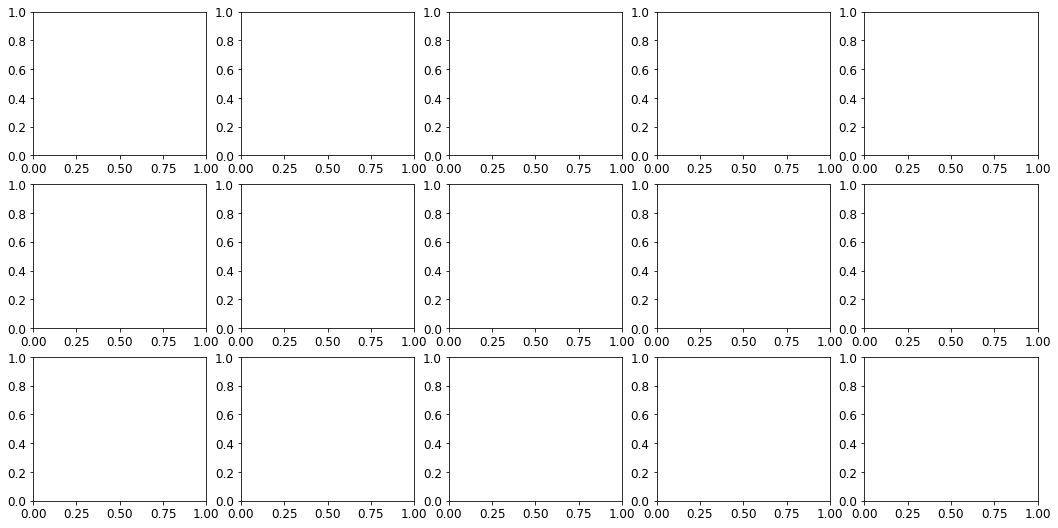

In [9]:
tlw = 2

fact = 1
fig, axs = plt.subplots(3,5, figsize=(18*fact, 9*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
wspdset = [wspd_1A, wspd_1B, wspd_2A, wspd_2B, wspd_3A, wspd_3B]
scens = ['1A', '1B', '2A', '2B', '3A', '3B']
var = 'Cflx'

wspd_2A_50 = wspd_2A.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))
wspd_2B_50 = wspd_2B.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))

wspdset_o3 = [(wspd_3B-wspd_2B), (wspd_3A-wspd_2A), (wspd_1B-wspd_2B), (wspd_1A-wspd_2A)]
scens_o3 = ['1990-fixed \n (high temp.)', '1990-fixed \n (low temp.)','hist.-fixed \n (high temp.)', 'hist.-fixed \n (low temp.)']
scens_o3 = ['ozone depl.-fixed ozone \n (SSP 3-7.0)', 'ozone depl.-fixed ozone \n (SSP 1-2.6)',\
            'ozone rec .-fixed ozone \n (SSP 3-7.0)', 'ozone rec .-fixed ozone \n (SSP 1-2.6)']

cols_o3 = ['#822722', '#FF462B', '#87800A', '#E8D215']
cols_t = ['dimgrey', 'silver']
scens_t = ['fixed ozone - fixed ozone$_\overline{1950-1960}$ \n (SSP 3-7.0)',\
           'fixed ozone - fixed ozone$_\overline{1950-1960}$ \n (SSP 1-2.6)']


############## lines
tits = ['full year','DJF','MAM','JJA','SON',]
for i in range(0,5):
    axs[i].set_title(tits[i])

for x in range(0,6):
    tsc = scens[x]
    wspd = wspdset[x]
    
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = 2, alpha = 1, label = scendict[tsc]['name2'])
      
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = 2, alpha = 1, label = scendict[tsc]['name2'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = 2, alpha = 1, label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = 2, alpha = 1, label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4], color = scendict[tsc]['color'], linewidth = 2, alpha = 1)

##########################
# #### ozone effect

ind = 5
for x in range(0,4):
    tsc = scens_o3[x]
    wspd = wspdset_o3[x]
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0+ind], color = cols_o3[x], linewidth = tlw, alpha = 1, label = scens_o3[x])    
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1+ind], color = cols_o3[x], linewidth = tlw, alpha = 1, label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2+ind], color = cols_o3[x], linewidth = tlw, alpha = 1, label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3+ind], color = cols_o3[x], linewidth = tlw, alpha = 1)
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4+ind], color = cols_o3[x], linewidth = tlw, alpha = 1)
    
# ######################
# #### temperature effect
ind = 10
tv = wspd_2B[var].groupby('time_counter.year').mean()-\
wspd_2B_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])

tv = wspd_2B[var].sel(time_counter=(wspd_2B['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
wspd_2B_50[var].sel(time_counter=(wspd_2B_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])

tv = wspd_2B[var].sel(time_counter=(wspd_2B['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
wspd_2B_50[var].sel(time_counter=(wspd_2B_50['time_counter.season'] == 'MAM')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])
    
tv = wspd_2B[var].sel(time_counter=(wspd_2B['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
wspd_2B_50[var].sel(time_counter=(wspd_2B_50['time_counter.season'] == 'JJA')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])

tv = wspd_2B[var].sel(time_counter=(wspd_2B['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
wspd_2B_50[var].sel(time_counter=(wspd_2B_50['time_counter.season'] == 'SON')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])    
    
tv = wspd_2A[var].groupby('time_counter.year').mean()-\
wspd_2A_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])

tv = wspd_2A[var].sel(time_counter=(wspd_2A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
wspd_2A_50[var].sel(time_counter=(wspd_2A_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])

tv = wspd_2A[var].sel(time_counter=(wspd_2A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
wspd_2A_50[var].sel(time_counter=(wspd_2A_50['time_counter.season'] == 'MAM')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])
    
tv = wspd_2A[var].sel(time_counter=(wspd_2A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
wspd_2A_50[var].sel(time_counter=(wspd_2A_50['time_counter.season'] == 'JJA')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])

tv = wspd_2A[var].sel(time_counter=(wspd_2A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
wspd_2A_50[var].sel(time_counter=(wspd_2A_50['time_counter.season'] == 'SON')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])  
#############################################


    
### bar graph
# ind = 15; tseas = 'FY'
# plot_effects(ind,tseas)
# axs[ind].set_xticks(np.arange(1,7,1))
# axs[ind].set_xticklabels(['warming \n(SSP1-2.6)', 'warming \n (SSP3-7.0)', 'ozone rec. \n (SSP 1-2.6)',\
#                          'ozone rec. \n (SSP 3-7.0)','ozone depl. \n (SSP 1-2.6)','ozone depl. \n (SSP 3-7.0)'], rotation = 80)
# ind = 16; tseas = 'DJF'
# plot_effects(ind,tseas)
# axs[ind].set_xticks(np.arange(0,6,1))
# axs[ind].set_xticklabels(['','','','','','',], rotation = 60)
# ind = 17; tseas = 'MAM'
# plot_effects(ind,tseas)
# axs[ind].set_xticks(np.arange(0,6,1))
# axs[ind].set_xticklabels(['','','','','','',], rotation = 60)
# ind = 18; tseas = 'JJA'
# plot_effects(ind,tseas)
# axs[ind].set_xticks(np.arange(0,6,1))
# axs[ind].set_xticklabels(['','','','','','',], rotation = 60)
# ind = 19; tseas = 'SON'
# plot_effects(ind,tseas)
# axs[ind].set_xticks(np.arange(0,6,1))
# axs[ind].set_xticklabels(['','','','','','',], rotation = 60)

##################
### titles, etc
plt.subplots_adjust(hspace = 0.48 )
plt.subplots_adjust(wspace = 0.28 )
t1 = 'wind speed, 1950-2100'
t2 = 'effect of ozone concentration changes on Cflx, 1950-2100'
t3 = 'effect of GHG emissions on Cflx, 1950-2100'
t4 = 'effect of ozone concentration changes and GHG emissions on Cflx, $\overline{2090-2100} - \overline{1950-1960}$'

fs = 16

# plt.figtext(0.5,0.92, t1, ha="center", va="top", fontsize=fs, color="k")
# plt.figtext(0.5,0.71, t2, ha="center", va="top", fontsize=fs, color="k")
# plt.figtext(0.5,0.5, t3, ha="center", va="top", fontsize=fs, color="k")
# plt.figtext(0.5,0.3, t4, ha="center", va="top", fontsize=fs, color="k")

# #####
# for ind in range(15,20):
#     axs[ind].axhline(y=0, color = 'k', linewidth = 0.5)
#     axs[ind].set_ylim(-0.2,0.82)


for i in range(0,15):
    axs[i].tick_params(axis="x", direction="out", length=1, width=1, color="turquoise")
    axs[i].grid(alpha = 0.5)
    
for i in range(0,15):
    axs[i].set_xlim([1950,2100])
    axs[i].set_xlabel('')
    
for i in range(1,15):
    axs[i].set_xlim([1950,2100])
    axs[i].set_ylabel('')
    
for i in range(0,15):
    #axs[i].set_xlim([1950,2100])
    #axs[i].set_ylabel('')
    axs[i].axhline(y=0, color = 'grey')
    
lab = ['a)','b)','c)','d)','e)',] 
ymi = np.array([8.7,7.5,9.5,9.25,8.7])  
hi = 2
#for i in range(0,5):
    #axs[i].set_ylim([ymi[i],ymi[i]+hi])
    #axs[i].text(1960,ymi[i]+0.85*hi,lab[i])
    
lab = ['f)','g)','h)','i)','j)']  
ymi = np.array([-0.1,-0.1,-0.1,-0.3,-0.25])  
hi = 1.2
#for i in range(0,5):
    #axs[i+5].set_ylim([ymi[i],ymi[i]+hi])
    #axs[i+5].text(1960,ymi[i]+0.85*hi,lab[i])
    
lab = ['k)','l)','m)','n)','o)']  
ymi = np.array([-0.25,-0.27,-0.15,-0.25,-0.27])  
#for i in range(0,5):
    #axs[i+10].set_ylim([ymi[i],ymi[i]+hi])
    #axs[i+10].text(1960,ymi[i]+0.85*hi,lab[i])
    
lab = ['p)','q)','r)','s)','t)']  
ymi = np.array([-0.2,-0.2,-0.2,-0.2,-0.2])
hi = 1.1
# for i in range(0,5):
#     axs[i+15].set_ylim([ymi[i],ymi[i]+hi])
#     axs[i+15].set_xlim([0.7,6.5])
#     axs[i+15].text(1,ymi[i]+0.85*hi,lab[i])

tits = ['full year','DJF','MAM','JJA','SON',]
for i in range(0,5):
    axs[i].set_title(tits[i])
    
# axs[7].legend(fontsize = 8)
# axs[12].legend()
#plt.tight_layout()
#fig.savefig('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/figs/Fig-windline.jpg')

plt.subplots_adjust(hspace = 0.48 )
plt.subplots_adjust(wspace = 0.28 )
t1 = 'wind speed, 1950-2100'
t2 = 'effect of ozone concentration changes on cflx, 1950-2100'
t3 = 'effect of GHG emissions on cflx, 1950-2100'

axs[0].set_ylabel('pG')
axs[5].set_ylabel('pG')
axs[10].set_ylabel('pG')


fs = 16
plt.subplots_adjust(hspace = 0.48 )
plt.subplots_adjust(wspace = 0.28 )
plt.figtext(0.5,0.94, t1, ha="center", va="top", fontsize=fs, color="k")
plt.figtext(0.5,0.64, t2, ha="center", va="top", fontsize=fs, color="k")
plt.figtext(0.5,0.36, t3, ha="center", va="top", fontsize=fs, color="k")
#plt.figtext(0.5,0.3, t4, ha="center", va="top", fontsize=fs, color="k")


fname = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/figs/Fig-cflx.jpg'
fig.savefig(fname, transparent=None, dpi=250, format=None,
        metadata=None, bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto', backend=None,
       )

In [ ]:
fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tits = ['full year','DJF','MAM','JJA','SON',]
for i in range(0,5):
    axs[i].set_title(tits[i])

for x in range(0,6):
    tsc = scens[x]
    wspd = wspdset[x]
    
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = 2, alpha = 1, label = scendict[tsc]['name2'])
      
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = 2, alpha = 1, label = scendict[tsc]['name2'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = 2, alpha = 1, label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = 2, alpha = 1, label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4], color = scendict[tsc]['color'], linewidth = 2, alpha = 1)

for i in range(0,5):
    axs[i].set_title(tits[i])

    
plt.tight_layout()

In [ ]:
w = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_diadT_aux/medusa_cj198o_1m_19501201-19510101_diad-T.nc')

w.CO2FLUX

In [ ]:
extract = False
if extract:
    scendict = {
        # Baynes Sound
        '1A': {
            'hist_str': 'bc370',
            'fut_str': 'be682',
            'name': 'HIST.OZONE \n LOW TEMP.',
            'name2':'1A: NatlOzone-SSP126',
            'color':'#E8D215',
            'color2':'orange'},
        '1B': {
            'hist_str': 'bc370',
            'fut_str': 'ce417',
            'name': 'HIST. OZONE \n HIGH TEMP.',
            'name2':'1B: NatlOzone-SSP370',
            'color':'#87800A',
            'color2':'orangered'},
        '2A': {
            'hist_str': 'cj198',
            'fut_str': 'cj880',
            'name': 'FIXED OZONE \n LOW TEMP.',
            'name2':'2A: Ozone1950-SSP126',
            'color':'#2DC18E',
            'color2':'mediumseagreen'},
        '2B': {
            'hist_str': 'cj198',
            'fut_str': 'cj881',
            'name': 'FIXED OZONE \n HIGH TEMP.',
            'name2':'2B: Ozone1950-SSP370',
            'color':'#18765C',
            'color2':'green'},
        '3A': {
            'hist_str': 'cj200',
            'fut_str': 'cj484',
            'name': '1990 OZONE \n LOW TEMP.',
            'name2':'3A: Ozone1990-SSP126',
            'color':'#FF462B',
            'color2':'dodgerblue'},
        '3B': {
            'hist_str': 'cj200',
            'fut_str': 'cj504',
            'name': '1990 OZONE \n HIGH TEMP.',
            'name2':'3B: Ozone1990-SSP370',
            'color':'#822722',
            'color2':'mediumblue'}
    }

    def make_yearlist_ukesm(yrst, yren, tscen, dtype = 'grid-T'):
        print(f'SCENARIO {tscen}')
        dslist = []

        for y in range(yrst,yren):
            if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
                tstr = scendict['1A']['hist_str']
            elif y<2015:
                tstr = scendict[tscen]['hist_str']

            else:
                tstr = scendict[tscen]['fut_str']

            try:
                td = glob.glob(f'/gpfs/data/greenocean/software/resources/MEDUSA/PROC2/*{tstr}*{y}*{dtype}*')
                dslist.append(td[0])
            except:
                pass
                print(f'FAIL {tscen},{tstr}, {y}')
        return dslist


    ### 
    ukmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask_eORCA1_wrk.nc')
    ukmesh['area'] = ukmesh.tmask[0,:,:] * ukmesh.e1t[:,:] * ukmesh.e2t[:,:]
    #print('lol yes the area is correct now')

    ukesm1A = (make_yearlist_ukesm(1950,2100,'1A', dtype = 'aux'))
    ukesm1B = (make_yearlist_ukesm(1950,2100,'1B', dtype = 'aux'))
    ukesm2A = (make_yearlist_ukesm(1950,2100,'2A', dtype = 'aux'))
    ukesm2B = (make_yearlist_ukesm(1950,2100,'2B', dtype = 'aux'))
    ukesm3A = (make_yearlist_ukesm(1950,2100,'3A', dtype = 'aux'))
    ukesm3B = (make_yearlist_ukesm(1950,2100,'3B', dtype = 'aux'))

    def get_monthly_co2(ukesmlist, savenam):
        print(savenam)
        time1 = time.time()
        print(len(ukesmlist))
        cflx_array = np.zeros(len(ukesmlist))
        year = np.zeros(len(ukesmlist))
        for i in range(0,len(ukesmlist)):
            if i%10 == 0:
                print(i)
            test = xr.open_dataset(ukesmlist[i])
            byarea = test.CO2FLUX.sel(y=slice(0,114))*ukmesh.area.sel(y=slice(0,114))
            timed = byarea.sum(dim = ['y', 'x']) #
            timed_mmol_day = timed.groupby('time_counter.year').mean() * 1e-18 * 365 * 12 #mmol/day to pG/year
            year[i] = (timed_mmol_day.year.values)
            print(year[i])
            cflx_array[i] = (timed_mmol_day.values)


        data_vars = {'Cflx':(['year'], cflx_array,
        {'units': 'Pg/yr',
        'long_name':'Cflx'}),
        }
        # define coordinates
        coords = {'year': (['year'], year),
                }
        # define global attributes
        attrs = {'made in':'SOZONEwindAnalyis/oceanFields/cflx.ipynb',
        'desc': 'yearly medusa files, saving only variables of interest'
        }
        ds = xr.Dataset(data_vars=data_vars,
        coords=coords,
        attrs=attrs)
        ds.to_netcdf(savenam)

        time2 = time.time()
        print(time2-time1)

    get_monthly_co2(ukesm1A, './extracted-summary/Cflx_ukesm1A_SO.nc')
    get_monthly_co2(ukesm1B, './extracted-summary/Cflx_ukesm1B_SO.nc')
    get_monthly_co2(ukesm2A, './extracted-summary/Cflx_ukesm2A_SO.nc')
    get_monthly_co2(ukesm2B, './extracted-summary/Cflx_ukesm2B_SO.nc')
    get_monthly_co2(ukesm3A, './extracted-summary/Cflx_ukesm3A_SO.nc')
    get_monthly_co2(ukesm3B, './extracted-summary/Cflx_ukesm3B_SO.nc')

In [ ]:
extract = False
if extract:
    scendict = {
        # Baynes Sound
        '1A': {
            'hist_str': 'bc370',
            'fut_str': 'be682',
            'name': 'HIST.OZONE \n LOW TEMP.',
            'name2':'1A: NatlOzone-SSP126',
            'color':'#E8D215',
            'color2':'orange'},
        '1B': {
            'hist_str': 'bc370',
            'fut_str': 'ce417',
            'name': 'HIST. OZONE \n HIGH TEMP.',
            'name2':'1B: NatlOzone-SSP370',
            'color':'#87800A',
            'color2':'orangered'},
        '2A': {
            'hist_str': 'cj198',
            'fut_str': 'cj880',
            'name': 'FIXED OZONE \n LOW TEMP.',
            'name2':'2A: Ozone1950-SSP126',
            'color':'#2DC18E',
            'color2':'mediumseagreen'},
        '2B': {
            'hist_str': 'cj198',
            'fut_str': 'cj881',
            'name': 'FIXED OZONE \n HIGH TEMP.',
            'name2':'2B: Ozone1950-SSP370',
            'color':'#18765C',
            'color2':'green'},
        '3A': {
            'hist_str': 'cj200',
            'fut_str': 'cj484',
            'name': '1990 OZONE \n LOW TEMP.',
            'name2':'3A: Ozone1990-SSP126',
            'color':'#FF462B',
            'color2':'dodgerblue'},
        '3B': {
            'hist_str': 'cj200',
            'fut_str': 'cj504',
            'name': '1990 OZONE \n HIGH TEMP.',
            'name2':'3B: Ozone1990-SSP370',
            'color':'#822722',
            'color2':'mediumblue'}
    }

    def make_yearlist_ukesm(yrst, yren, tscen, dtype = 'grid-T'):
        print(f'SCENARIO {tscen}')
        dslist = []

        for y in range(yrst,yren):
            if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
                tstr = scendict['1A']['hist_str']
            elif y<2015:
                tstr = scendict[tscen]['hist_str']

            else:
                tstr = scendict[tscen]['fut_str']

            try:
                td = glob.glob(f'/gpfs/data/greenocean/software/resources/MEDUSA/PROC2/*{tstr}*{y}*{dtype}*')
                dslist.append(td[0])
            except:
                pass
                print(f'FAIL {tscen},{tstr}, {y}')
        return dslist


    ### 
    ukmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask_eORCA1_wrk.nc')
    ukmesh['area'] = ukmesh.tmask[0,:,:] * ukmesh.e1t[:,:] * ukmesh.e2t[:,:]
    #print('lol yes the area is correct now')

    ukesm1A = (make_yearlist_ukesm(1950,2100,'1A', dtype = 'aux'))
    ukesm1B = (make_yearlist_ukesm(1950,2100,'1B', dtype = 'aux'))
    ukesm2A = (make_yearlist_ukesm(1950,2100,'2A', dtype = 'aux'))
    ukesm2B = (make_yearlist_ukesm(1950,2100,'2B', dtype = 'aux'))
    ukesm3A = (make_yearlist_ukesm(1950,2100,'3A', dtype = 'aux'))
    ukesm3B = (make_yearlist_ukesm(1950,2100,'3B', dtype = 'aux'))

    def get_monthly_co2(ukesmlist, savenam):
        print(savenam)
        time1 = time.time()
        print(len(ukesmlist))
        cflx_array = np.zeros(len(ukesmlist))
        year = np.zeros(len(ukesmlist))
        for i in range(0,len(ukesmlist)):
            if i%10 == 0:
                print(i)
            test = xr.open_dataset(ukesmlist[i])
            byarea = test.CO2FLUX*ukmesh.area
            timed = byarea.sum(dim = ['y', 'x']) #
            timed_mmol_day = timed.groupby('time_counter.year').mean() * 1e-18 * 365 * 12 #mmol/day to pG/year
            year[i] = (timed_mmol_day.year.values)
            print(year[i])
            cflx_array[i] = (timed_mmol_day.values)


        data_vars = {'Cflx':(['year'], cflx_array,
        {'units': 'Pg/yr',
        'long_name':'Cflx'}),
        }
        # define coordinates
        coords = {'year': (['year'], year),
                }
        # define global attributes
        attrs = {'made in':'SOZONEwindAnalyis/oceanFields/cflx.ipynb',
        'desc': 'yearly medusa files, saving only variables of interest'
        }
        ds = xr.Dataset(data_vars=data_vars,
        coords=coords,
        attrs=attrs)
        ds.to_netcdf(savenam)

        time2 = time.time()
        print(time2-time1)

    get_monthly_co2(ukesm1A, './extracted-summary/Cflx_ukesm1A.nc')
    get_monthly_co2(ukesm1B, './extracted-summary/Cflx_ukesm1B.nc')
    get_monthly_co2(ukesm2A, './extracted-summary/Cflx_ukesm2A.nc')
    get_monthly_co2(ukesm2B, './extracted-summary/Cflx_ukesm2B.nc')
    get_monthly_co2(ukesm3A, './extracted-summary/Cflx_ukesm3A.nc')
    get_monthly_co2(ukesm3B, './extracted-summary/Cflx_ukesm3B.nc')

In [ ]:
wspd_1A_SO = xr.open_dataset(f'{baseDir}/Cflx_ukesm1A_SO.nc')
wspd_2A_SO = xr.open_dataset(f'{baseDir}/Cflx_ukesm2A_SO.nc')
wspd_3A_SO = xr.open_dataset(f'{baseDir}/Cflx_ukesm3A_SO.nc')
wspd_1B_SO = xr.open_dataset(f'{baseDir}/Cflx_ukesm1B_SO.nc')
wspd_2B_SO = xr.open_dataset(f'{baseDir}/Cflx_ukesm2B_SO.nc')
wspd_3B_SO = xr.open_dataset(f'{baseDir}/Cflx_ukesm3B_SO.nc')

wspd_1A = xr.open_dataset(f'{baseDir}/Cflx_ukesm1A.nc')
wspd_2A = xr.open_dataset(f'{baseDir}/Cflx_ukesm2A.nc')
wspd_3A = xr.open_dataset(f'{baseDir}/Cflx_ukesm3A.nc')
wspd_1B = xr.open_dataset(f'{baseDir}/Cflx_ukesm1B.nc')
wspd_2B = xr.open_dataset(f'{baseDir}/Cflx_ukesm2B.nc')
wspd_3B = xr.open_dataset(f'{baseDir}/Cflx_ukesm3B.nc')

In [ ]:
#atmco2.dat.variable:/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp1-26.dat

In [ ]:
wspd_1A = xr.open_dataset(f'{baseDir}/Cflx_ukesm1A.nc')

In [ ]:
fact = 1
fig, axs = plt.subplots(1,2, figsize=(18*fact, 9*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
wspdset = [wspd_1A, wspd_1B, wspd_2A, wspd_2B, wspd_3A, wspd_3B]
scens = ['1A', '1B', '2A', '2B', '3A', '3B']
var = 'Cflx'
wspdset2 = [wspd_1A_SO, wspd_1B_SO, wspd_2A_SO, \
wspd_2B_SO, wspd_3A_SO, wspd_3B_SO,]
############## lines


for x in range(0,6):
    tsc = scens[x]
    wspd = wspdset[x]
    tv = wspd[var]
    tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = 1, alpha = 1)

    tsc = scens[x]
    wspd = wspdset2[x]
    tv = wspd[var]
    tv.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = 1, alpha = 1)
    
tits = ['full year, full globe','full year, SO (south of -50)',]
for i in range(0,2):
    axs[i].set_title(tits[i])

In [ ]:
wspd_1Adf = wspd_1A.to_dataframe().to_csv('./extracted-summary/yearlycsvs/Cflx-Pgyr-ozoneHIST-SSP1.csv')
wspd_2Adf = wspd_2A.to_dataframe().to_csv('./extracted-summary/yearlycsvs/Cflx-Pgyr-ozoneFIXED-SSP1.csv')
wspd_3Adf = wspd_3A.to_dataframe().to_csv('./extracted-summary/yearlycsvs/Cflx-Pgyr-ozone1990-SSP1.csv')

wspd_1Bdf = wspd_1B.to_dataframe().to_csv('./extracted-summary/yearlycsvs/Cflx-Pgyr-ozoneHIST-SSP3.csv')
wspd_2Bdf = wspd_2B.to_dataframe().to_csv('./extracted-summary/yearlycsvs/Cflx-Pgyr-ozoneFIXED-SSP3.csv')
wspd_3Bdf = wspd_3B.to_dataframe().to_csv('./extracted-summary/yearlycsvs/Cflx-Pgyr-ozone1990-SSP3.csv')

In [ ]:
wspd_1Adf = wspd_1A_SO.to_dataframe().to_csv('./extracted-summary/yearlycsvs/Cflx-Pgyr-ozoneHIST-SSP1_SO.csv')
wspd_2Adf = wspd_2A_SO.to_dataframe().to_csv('./extracted-summary/yearlycsvs/Cflx-Pgyr-ozoneFIXED-SSP1_SO.csv')
wspd_3Adf = wspd_3A_SO.to_dataframe().to_csv('./extracted-summary/yearlycsvs/Cflx-Pgyr-ozone1990-SSP1_SO.csv')

wspd_1Bdf = wspd_1B_SO.to_dataframe().to_csv('./extracted-summary/yearlycsvs/Cflx-Pgyr-ozoneHIST-SSP3_SO.csv')
wspd_2Bdf = wspd_2B_SO.to_dataframe().to_csv('./extracted-summary/yearlycsvs/Cflx-Pgyr-ozoneFIXED-SSP3_SO.csv')
wspd_3Bdf = wspd_3B_SO.to_dataframe().to_csv('./extracted-summary/yearlycsvs/Cflx-Pgyr-ozone1990-SSP3_SO.csv')

In [ ]:
w = pd.read_csv('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/yearlycsvs/Cflx-Pgyr-ozoneHIST-SSP1.csv')

In [ ]:
w = pd.read_csv('/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp1-26.dat', sep  = '\t')

In [ ]:
co2_ssp1 = '/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp1-26.dat'
co2_ssp3 = '/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp3-70.dat'

atmo_co2_ssp1 = pd.read_csv(co2_ssp1, sep='\t')
atmo_co2_ssp3 = pd.read_csv(co2_ssp3, sep='\t')



yr = atmo_co2_ssp1['1650.042'].values
co2atm_ssp1 = atmo_co2_ssp1['276.58'].values
co2atm_ssp3 = atmo_co2_ssp3['276.58'].values


yrmns = np.arange(1950,2100,1)
yrmn_co2_ssp1 = np.arange(1950,2100,1)
yrmn_co2_ssp1 = yrmn_co2_ssp1.astype('float')
yrmn_co2_ssp3 = np.arange(1950,2100,1)
yrmn_co2_ssp3 = yrmn_co2_ssp3.astype('float')


for i in range(1950,2100):
    yrmn_co2_ssp1[i-1950] = np.nanmean(co2atm_ssp1[(yr >= i) & (yr< i+1)])
    yrmn_co2_ssp3[i-1950] = np.nanmean(co2atm_ssp3[(yr >= i) & (yr< i+1)])

    
atmo_2002 = (yrmn_co2_ssp1[yrmns == 2002])

plt.plot(yrmns,yrmn_co2_ssp1)
plt.plot(yrmns,yrmn_co2_ssp3)

In [ ]:
df = pd.DataFrame({'year': yrmns, 'atmco2': yrmn_co2_ssp1})
df.to_csv(('./extracted-summary/yearlycsvs/atmco2-SSP1.csv'))
df = pd.DataFrame({'year': yrmns, 'atmco2': yrmn_co2_ssp3})
df.to_csv(('./extracted-summary/yearlycsvs/atmco2-SSP3.csv'))

In [ ]:
plt.plot(df.year,df.atmco2)

In [ ]:
atmo_co2_ssp1[3700:3720]